In [1]:
import numpy as np
import pandas as pd
import json
from urllib.request import urlopen
import sqlite3
import string

import seaborn as sns
import matplotlib.pyplot as plt

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
import ast
from ast import literal_eval



#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models


#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

/Users/alicia/opt/anaconda3/envs/ada/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# General information Remark

### In the loading part we will recover data from 2015 to 2020, however, first visulation (part III) will only be on the data from 2020.

# I- Load the data

### Load Quotebank data

First, let's recover the quotations of interest : as our project is based on the caracterisation of the speaker, we decide to pre-select the quotations that are related to a speaker (i.e speaker value is different from 'None'). 
Moreover, we select the quotations whose subject is related to climate change : to do so we will recover a list of keyword related to climate subject by analyzing wwith NLP the dataset train_climate.tcsv. Then, we select quotes that contains at least one of these words(cf chunk_filtering method).

> #### A/ Recovering of the keyword list 

In [23]:
data1 = pd.read_csv('data/Wiki_train.tsv', sep='\t')
data2=pd.read_csv('data/train_1.tsv', sep='\t')

In [24]:
data1.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)
data2.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)

In [25]:
subdata = pd.concat([data1, data2])

> ##### Creation of our bag of word 

In [26]:
vectorizer = CountVectorizer(stop_words = 'english',ngram_range=(1, 2),lowercase=False)


#create bag of words features
X = vectorizer.fit_transform(subdata.sentence)


print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int climate
Y = np.array(subdata.label)



print(Y.shape)
print(X.shape)
#shuffle the data

X, Y = shuffle(X, Y, random_state=0)



#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 6000
Number of features: 75261
(6000,)
(6000, 75261)


In [27]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf=tfidf_transformer.fit_transform(X_test)
#transform the count matrix X_train to a normalized tf-idf representation
X_train_tfidf.shape 
X_test_tfidf

<1200x75261 sparse matrix of type '<class 'numpy.float64'>'
	with 26161 stored elements in Compressed Sparse Row format>

In [28]:
train = [X_train, X_train_tfidf]
test = [X_test, X_test_tfidf]

In [29]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000] 


param_grid = dict(C=C) 

logistic = LogisticRegression(solver = 'lbfgs', penalty = 'l2') 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9394273127753303
Best Params:  {'C': 0.1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9443832599118943
Best Params:  {'C': 10}


In [30]:
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log', 'hinge']
max_iter=[1000, 10000, 100000, 1e6]
n_jobs = [-1]


param_grid = dict(penalty=penalty, 
alpha=alpha,loss=loss,max_iter=max_iter, n_jobs=n_jobs) 

logistic = SGDClassifier() 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9288673331074213
Best Params:  {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 10000, 'n_jobs': -1, 'penalty': 'l2'}
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9418417485598102
Best Params:  {'alpha': 0.0001, 'loss': 'log', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}


In [31]:
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 10, penalty='l2').fit(X_train_tfidf, Y_train)
predicted = clf.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.9508333333333333


In [32]:
coefs=clf.coef_[0]
top_three = np.argpartition(coefs, -30)[-30:]
print(np.array(vectorizer.get_feature_names_out())[top_three])

['gases' 'fuels' 'diesel' 'greenhouse gases' 'levels' 'increase' 'gas'
 'warmer' 'carbon tax' '2010' 'climate change' 'precipitation' 'emission'
 'change' 'glaciers' 'policy' 'GHG' 'global warming' 'global' 'greenhouse'
 'cap' 'temperatures' 'Glacier' 'warming' 'increased' 'fuel' 'carbon'
 'climate' 'Climate' 'emissions']


In [33]:
clf_sdg = SGDClassifier(loss="log", penalty="l2", alpha = 0.0001,   max_iter=1e6, n_jobs=-1).fit(X_train_tfidf, Y_train)
predicted = clf_sdg.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.95


In [34]:
coefs_sdg=clf_sdg.coef_[0]
top_three_sdg = np.argpartition(coefs_sdg, -30)[-30:]

print(np.array(vectorizer.get_feature_names_out())[top_three_sdg])

['energy' 'greenhouse gases' 'temperature' 'gases' 'precipitation' 'CO'
 '2010' 'change' 'levels' 'emission' 'warmer' 'fuels' 'diesel' 'GHG'
 'fuel' 'glaciers' 'temperatures' 'emissions' 'increased' 'Climate' 'gas'
 'global' 'cap' 'carbon' 'Glacier' 'global warming' 'warming' 'climate'
 'greenhouse' 'policy']


In [35]:
keywords = np.array(vectorizer.get_feature_names_out())[top_three]
keywords=np.delete(keywords, [4, 5, 9, 15, 18, 24])

In [36]:
keywords



array(['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'change', 'glaciers', 'GHG', 'global warming', 'greenhouse', 'cap',
       'temperatures', 'Glacier', 'warming', 'fuel', 'carbon', 'climate',
       'Climate', 'emissions'], dtype=object)

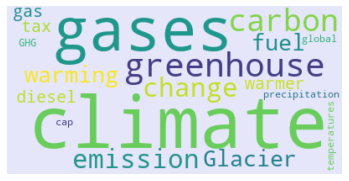

In [47]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import ast
listToStr = ' '.join([str(elem) for elem in keywords])
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color = 'lavender').generate(listToStr)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

> #### B/ Recover climate quotation from Quotebank

In [31]:
def chunk_filtering(chunk, lst):
    template=[] #Creation of an empty list :it's always cheaper to append to a list and create a DataFrame than append on a empty dataframe.
    for i in lst: 
        template.append(chunk.loc[chunk["quotation"].apply(lambda x : i in x) & 
                                  chunk["speaker"].apply(lambda x: x!= "None")&
                                  chunk["qids"].apply(lambda x: len(np.array(x))==1)].drop(['phase'], axis=1))
        #Select quotations with value in speaker column different from 'None' and quotations containing the key word and drop Phase column. 
        #As the speaker is identified by their name and not their QID, we select the ones that have a unique QID to facilitate our analysis.
        
    return (pd.concat(template, ignore_index=True))# return a dataframe with our data of interest

In [32]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_json(f'data/quotes-{date}.json.bz2', lines=True, compression='bz2', chunksize=1000)

In [21]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

In [5]:
print(" At result, we extracted {} quotes fromes quotebank data".format(length))

 At result, we extracted 2324231 quotes fromes quotebank data


Even with key_word selection we success to extract a satisfying quantity of data from the Quotebank data. 

## Load additional data Relative to speakers

### Extracted labels from QID 

The provided speaker_attributes.parquet file contains attributes in terms of QIDs, thereby being uninterpretable by humans (df_qid).
To map the QIDs to meaningful labels, we used the provided wikidata_labels_descriptions_quotebank.csv.bz2 containing the label and value for the respective QID containing the df_qid (df_label_qid).
By combining the information of both we can obtained usefull information about speakers. 

#### *Load parquet file*

In [4]:
#Loading our speakers attribute dataset, and the dataset necessary to interpret our QIDs.
df_qid = pd.read_parquet("speaker_attributes.parquet",engine= "pyarrow" )
df_label_qid = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv',index_col='QID')

#### *Somes visualisation and sort of the parquet file*

First let's check if the identifier are unique.

In [5]:
df_qid.id.is_unique

True

Before extract the label of QID, let's check which column we want to keep in frame with our project.

In [6]:
df_qid.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


Let's verify that academic_degree has revelant values.

In [7]:
print("There's no academic degree revelant value ? {}".format(all(df_qid.academic_degree.isna())))

There's no academic degree revelant value ? False


It seems that academic degree values are revelant, we decided to drop lastrevid, US_congress_bio_ID, type, Alisiase as they will not be used in our project.

In [8]:
df_qid.drop(['lastrevid', 'US_congress_bio_ID', 'type', 'aliases'], axis=1, inplace=True)

#### *Transformation of the df_qid with the label value from df_label_qid*

In [10]:
#We found that one of the QID was deleted from Wikidata. We will start by dropping this value, so that it does not distrurb our labelling. 

def transform(y):
    if y is None: return None
    x = set(y)
    x.discard("Q99753484")
    return np.array(list(x))
    
df_qid['occupation']=df_qid['occupation'].apply(lambda y : transform(y))

In [11]:
#We found out that some of the QIDs used in the speaker attribute file are actually redirection from an original QID. 
#We will manulally add their corresponding information using the orginal QID. We found the corespondance manualy between the two. 
#Here, there are in order, respectively the redirection QID, and its corresponding original one. One of he QID was only present 
#as a redirection, so we manually added this one (Q3186984), and its corresponding info. 

redirect_QID=['Q3268166', 'Q11815360', 'Q12014399', 'Q16287483',
              'Q20432251', 'Q21550646', 'Q13365117', 'Q13424794',
             'Q1248362', 'Q6859927', 'Q15145782',
             'Q15991263', 'Q12455619', 'Q5568256', 
             'Q6363085', 'Q11819457', 'Q12334852', 'Q15145783']
actual_QID=['Q1113899', 'Q1919436', 'Q250867', 'Q6051619',
             'Q26934816', 'Q18431816', 'Q12840545', 'Q5157338',
            'Q3455803', 'Q715222', 'Q1052281',
            'Q2743689', 'Q7019111', 'Q3738699', 
            'Q380075', 'Q3391743', 'Q476246', 'Q2449503']


lst=[['Journalist', 'monthly magazine of the United Kingdom‘s National Union of Journalists (NUJ)']]
indexes=['Q3186984']
col=['Label', 'Description']
for i in range(len(redirect_QID)):
    lst.append([df_label_qid.loc[actual_QID[i]]['Label'], 
                df_label_qid.loc[actual_QID[i]]['Description']])
    indexes.append(redirect_QID[i])

additional_df= pd.DataFrame(lst, columns= col, index=indexes)
df_label=df_label_qid.append(additional_df, ignore_index= False)

In [12]:
#Applying the function to every column containing QIDs. 
cols=['nationality', 'gender', 'ethnic_group','occupation', 'party', 'academic_degree', 'candidacy', 'religion'] #List of columns 
#containing QID to be replace

df_qid[cols] = df_qid[cols].applymap(lambda d: d if d is not None else []) #Replacing every None value with an empty list for futur analysis.
df_qid[cols] = df_qid[cols].applymap(lambda y: [df_label.loc[Q].Label for Q in y]) #Replacing QIDs with their corresponding label.

### Let's have additional data 

Now, we want to see which speakers said quotes that we consider as climate-related and climate change sceptical. We will match speaker from the df_qid with a value septic/climate. We will add two boolean columns to our dataframe df_qid: one for climate-related, and one for climate change sceptical. In order to do that, we will select every QID that appears in our list of climate-related-quotes and climat-change-sceptical quotes

#### *Qid_climate list*

In [13]:
qid_climate=[]

#iteration in the dico_clean containing extracted files for climate involved quotes
for key, file in dico_clean.items() :
    qid_climate.append(file.drop_duplicates(['qids'], keep='first')['qids'].map(lambda y : ast.literal_eval(y)[0]).tolist()) #add unique QIDs from each file
qid_climate=set(item for sublist in qid_climate for item in sublist)#create a set with unique QIDs from each year/file.

In [14]:
print("We extracted {} QIDs related to speakers that talk about climate.".format(len(qid_climate)))

We extracted 255071 QIDs related to speakers that talk about climate.


#### *Add an additional column to df_qid*

In [15]:
df_qid['climate']=0 #create a column named climate with value equals 0
df_qid.loc[df_qid[pd.Index(df_qid.id.isin(pd.Index(qid_climate)))].index, 'climate']=1 #replace with 1 for speakers that appear in the climate-involved quotes.

In [16]:
df_qid.sample(10)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
6260638,None,[],[],[],[researcher],[],[],Q60398126,Tim Ryley,[],[],0
3686110,[+1811-00-00T00:00:00Z],[Qing dynasty],[male],[],[politician],[],[jinshi],Q15935968,Wenbin Gu,[],[],0
2822307,None,[],[],[],[researcher],[],[],Q56380944,Guillem Bagaria,[],[],0
2638823,[+1809-03-06T00:00:00Z],[Kingdom of Prussia],[male],[],"[teacher, high school teacher, classical philo...",[],[],Q21543832,Johann Karl August Goebel,[],[Protestantism],0
4334051,[+1979-09-20T00:00:00Z],[],[male],[],[],[],[],Q95168269,Roman Drga,[],[],0
7991459,"[+1916-11-18T00:00:00Z, +1916-02-18T00:00:00Z]",[Spain],[male],[],[association football player],[],[],Q2056018,José Bravo,[],[],0
2319796,[+1953-09-10T00:00:00Z],[Germany],[male],[],[painter],[],[],Q1609211,Herbert Tomm,[],[],0
627926,[+1987-01-22T00:00:00Z],[Israel],[male],[],[singer-songwriter],[],[],Q63203155,None,[],[],0
6156273,None,[Ming dynasty],[male],[],[],[],[],Q45661023,Li Changtai,[],[],0
2038034,None,[],[],[],[researcher],[],[],Q93104466,Howard L Parnes,[],[],0


#### *Load resulting data into a csv compressed filled*

In [7]:
df_qid.to_csv("data/speaker_attribute.bz2", compression = 'bz2', index=False)

NameError: name 'df_qid' is not defined

# II- Filter the data

As a good data scientist, the first thing to do is to clean up the data. In order to do that, we will first check for missing rows. Then we will replace the date of birth by the year of birth. Lastly, we will filter our speakers in order to keep only the ones whose age is bewteen 12 and 100 . (As climate change is a relatively new topic, and we do not consider quotes from speakers that are younger then 12 years old).

In [18]:
speakers=pd.read_csv("data/speaker_attribute.bz2", compression='bz2')

In [19]:
speakers.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
0,['+1732-02-22T00:00:00Z'],"['Great Britain', 'United States of America']",['male'],[],"['military officer', 'engineer', 'land surveyo...",['independent politician'],[],Q23,George Washington,"['1792 United States presidential election', '...",['Episcopal Church'],0
1,['+1952-03-11T00:00:00Z'],['United Kingdom'],['male'],['White British'],"['novelist', 'science fiction writer', 'comedi...",[],[],Q42,Douglas Adams,[],[],0
2,['+1868-08-23T00:00:00Z'],['Belgium'],['male'],[],"['bibliographer', 'inventor', 'librarian', 'la...",[],[],Q1868,Paul Otlet,[],[],0
3,['+1946-07-06T00:00:00Z'],['United States of America'],['male'],[],"['autobiographer', 'military officer', 'rugby ...",['Republican Party'],[],Q207,George W. Bush,"['2000 United States presidential election', '...","['United Methodist Church', 'Episcopal Church'...",1
4,['+1599-06-06T00:00:00Z'],['Spain'],['male'],[],['painter'],[],[],Q297,Diego Velázquez,[],[],0


> ##### *check for missing row*
We consider that a row is missing if we don't have information about speakers attributes (i.e other than label, qid)

In [20]:
print("Is there some missing rows ? {} ".format(np.array([speakers.drop(columns=['label', 'id']).isnull().any(axis=1)]).all()))

Is there some missing rows ? False 


> ##### *Clean and filter date of birth and speakers*

In [21]:
speakers.date_of_birth=speakers.fillna(0).date_of_birth.map(lambda y : str(y).split("-")[0][3:])#Keep only the year of birth.

In [22]:
speakers=speakers.loc[speakers['date_of_birth'].apply(lambda x: x!= '' and int(x)>1920 and int(x)< 2008)]#Keep only speakers born after 1920.

In [23]:
speakers['date_of_birth']=speakers['date_of_birth'].astype(int)

In [24]:
speakers.sample(5)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
8546482,1991,['United States of America'],['male'],['African Americans'],"['singer', 'songwriter', 'rapper']",[],[],Q62107457,DaBaby,[],[],0
3603031,1980,['United States of America'],['male'],[],"['American football player', 'Canadian footbal...",[],[],Q7812333,Todd Devoe,[],[],0
4452732,1975,['Denmark'],['male'],[],['association football player'],[],[],Q101827746,Jacob Juhl,[],[],0
8142218,1929,['Poland'],['male'],[],"['screenwriter', 'film director']",[],[],Q9348835,Sylwester Szyszko,[],[],0
4807008,1954,[],['male'],[],[],[],[],Q15048121,Henry Francis Hays,[],[],0


# III Classification

In [25]:
#function that removes the nan from the list of attributes 
def handle_nan(y) :
    try :
        return literal_eval(y)

    except Exception as e:
        y = y.replace("nan", "0")
        return literal_eval(y)

In [26]:
speakers.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
1,1952,['United Kingdom'],['male'],['White British'],"['novelist', 'science fiction writer', 'comedi...",[],[],Q42,Douglas Adams,[],[],0
3,1946,['United States of America'],['male'],[],"['autobiographer', 'military officer', 'rugby ...",['Republican Party'],[],Q207,George W. Bush,"['2000 United States presidential election', '...","['United Methodist Church', 'Episcopal Church'...",1
8,1945,"['Canada', 'United States of America']",['male'],[],"['autobiographer', 'actor', 'singer', 'record ...",[],[],Q633,Neil Young,[],[],0
9,1969,['Germany'],['male'],[],"['photographer', 'Wikimedian']",[],[],Q640,Harald Krichel,[],[],0
12,1932,"['Soviet Union', 'Russia']",['male'],[],"['theater director', 'actor', 'biographer', 'f...",[],[],Q853,Andrei Tarkovsky,[],['Eastern Orthodox Church'],0


In [27]:
columns_eval = ['occupation','religion','nationality','ethnic_group','party','academic_degree', 'gender'] #our columns of interest

In [28]:

speakers[columns_eval].applymap(handle_nan) #application of the function

,occupation,religion,nationality,ethnic_group,party,academic_degree,gender
1,"[novelist, science fiction writer, comedian, c...",[],[United Kingdom],[White British],[],[],[male]
3,"[autobiographer, military officer, rugby union...","[United Methodist Church, Episcopal Church, Me...",[United States of America],[],[Republican Party],[],[male]
8,"[autobiographer, actor, singer, record produce...",[],"[Canada, United States of America]",[],[],[],[male]
9,"[photographer, Wikimedian]",[],[Germany],[],[],[],[male]
12,"[theater director, actor, biographer, film edi...",[Eastern Orthodox Church],"[Soviet Union, Russia]",[],[],[],[male]
...,...,...,...,...,...,...,...
9055936,[],[],[],[],[],[],[male]
9055940,[association football player],[],[],[],[],[],[]
9055949,"[university teacher, scientist]",[],[Belarus],[],[],[Doctor in Engineering],[male]
9055950,[American football player],[],[],[],[],[],[male]


In [29]:
copie=speakers.copy()

In [30]:
#functions to create categorical columns  
def one_hot(list, column):
    for o in list: #Iterating over the list of genres. 
        copie[f'{o}'] = 0 #Creating a new onehot feature column for each genre, filling it with False.
        copie.loc[speakers[column].apply(lambda value : o in value), f'{o}'] = 1 #For each album, putting True in the 
    #onehot column corresponding to its genre. 

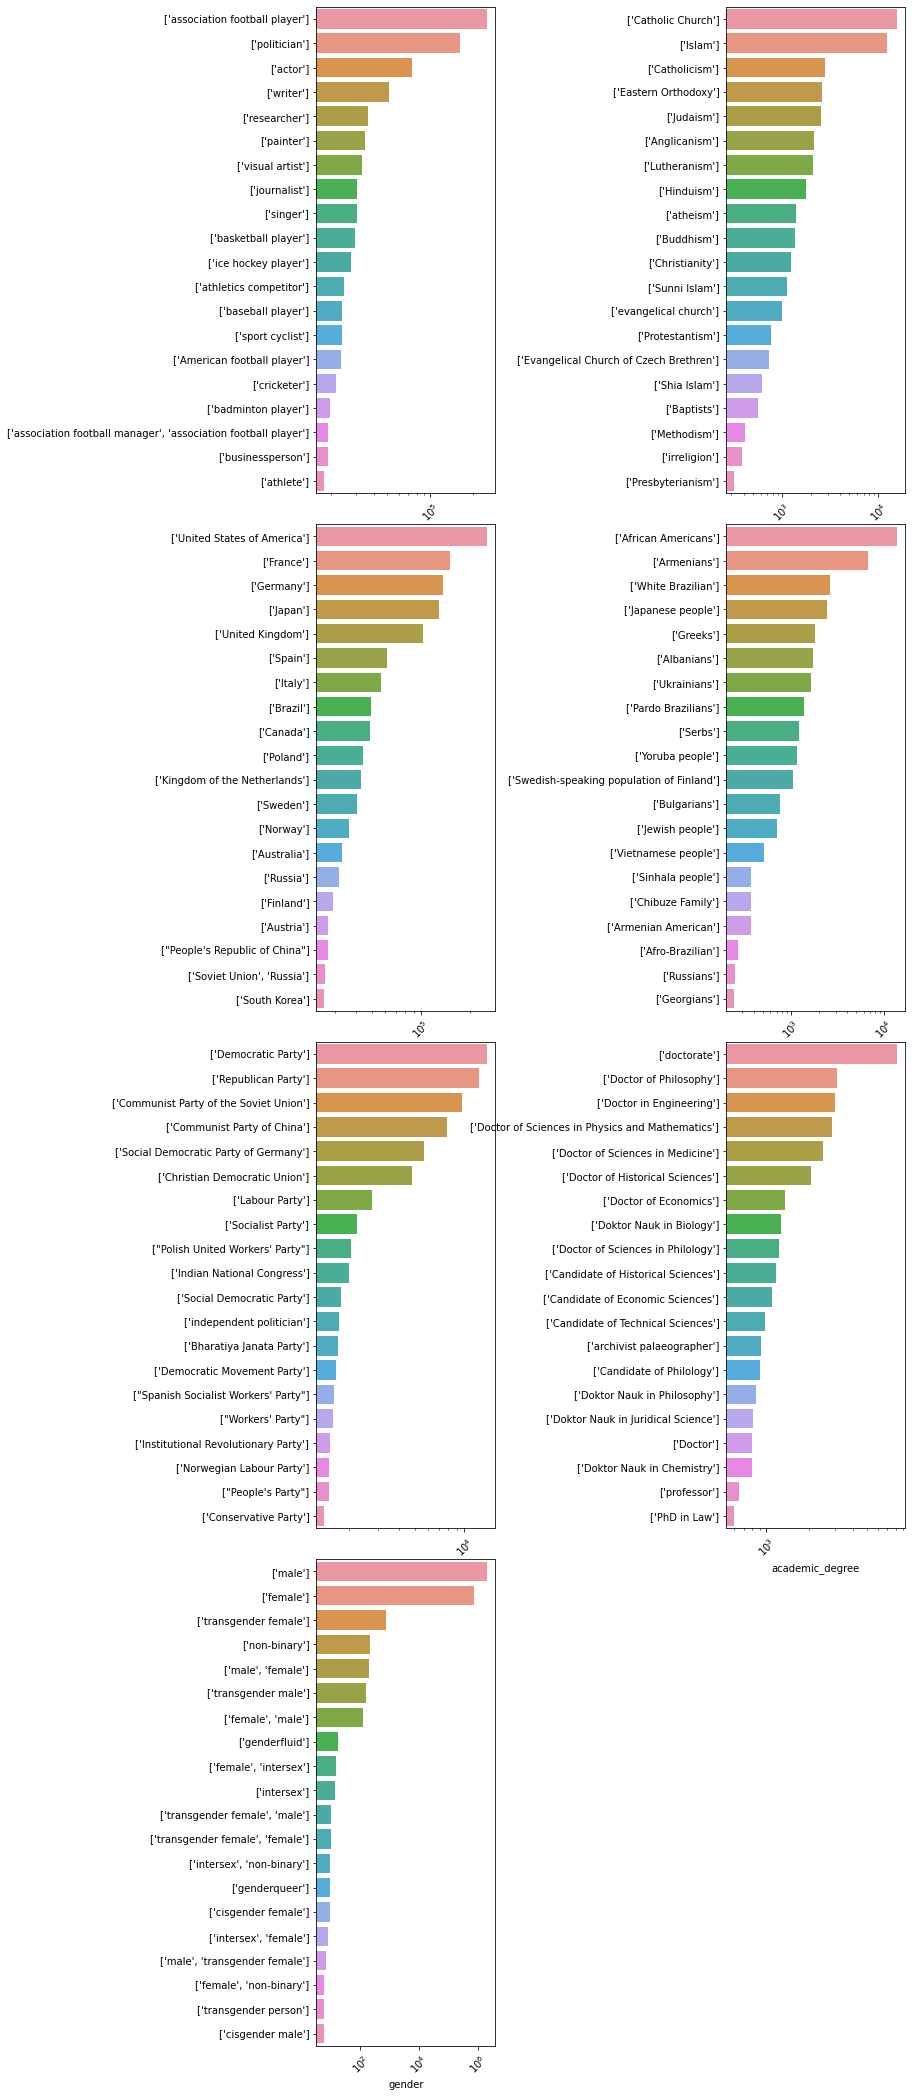

In [56]:
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]

fig, axs = plt.subplots(4,2, figsize=(10,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=5, w_pad=20, h_pad=1)


for idx, column in enumerate(columns_eval): 
    
    subdata=speakers[column].explode().value_counts().drop('[]')
    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]])
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')
    #one_hot(subdata.index.tolist()[0:20], column)
    

plt.show()

In [ ]:
#Let's see some major parameters 

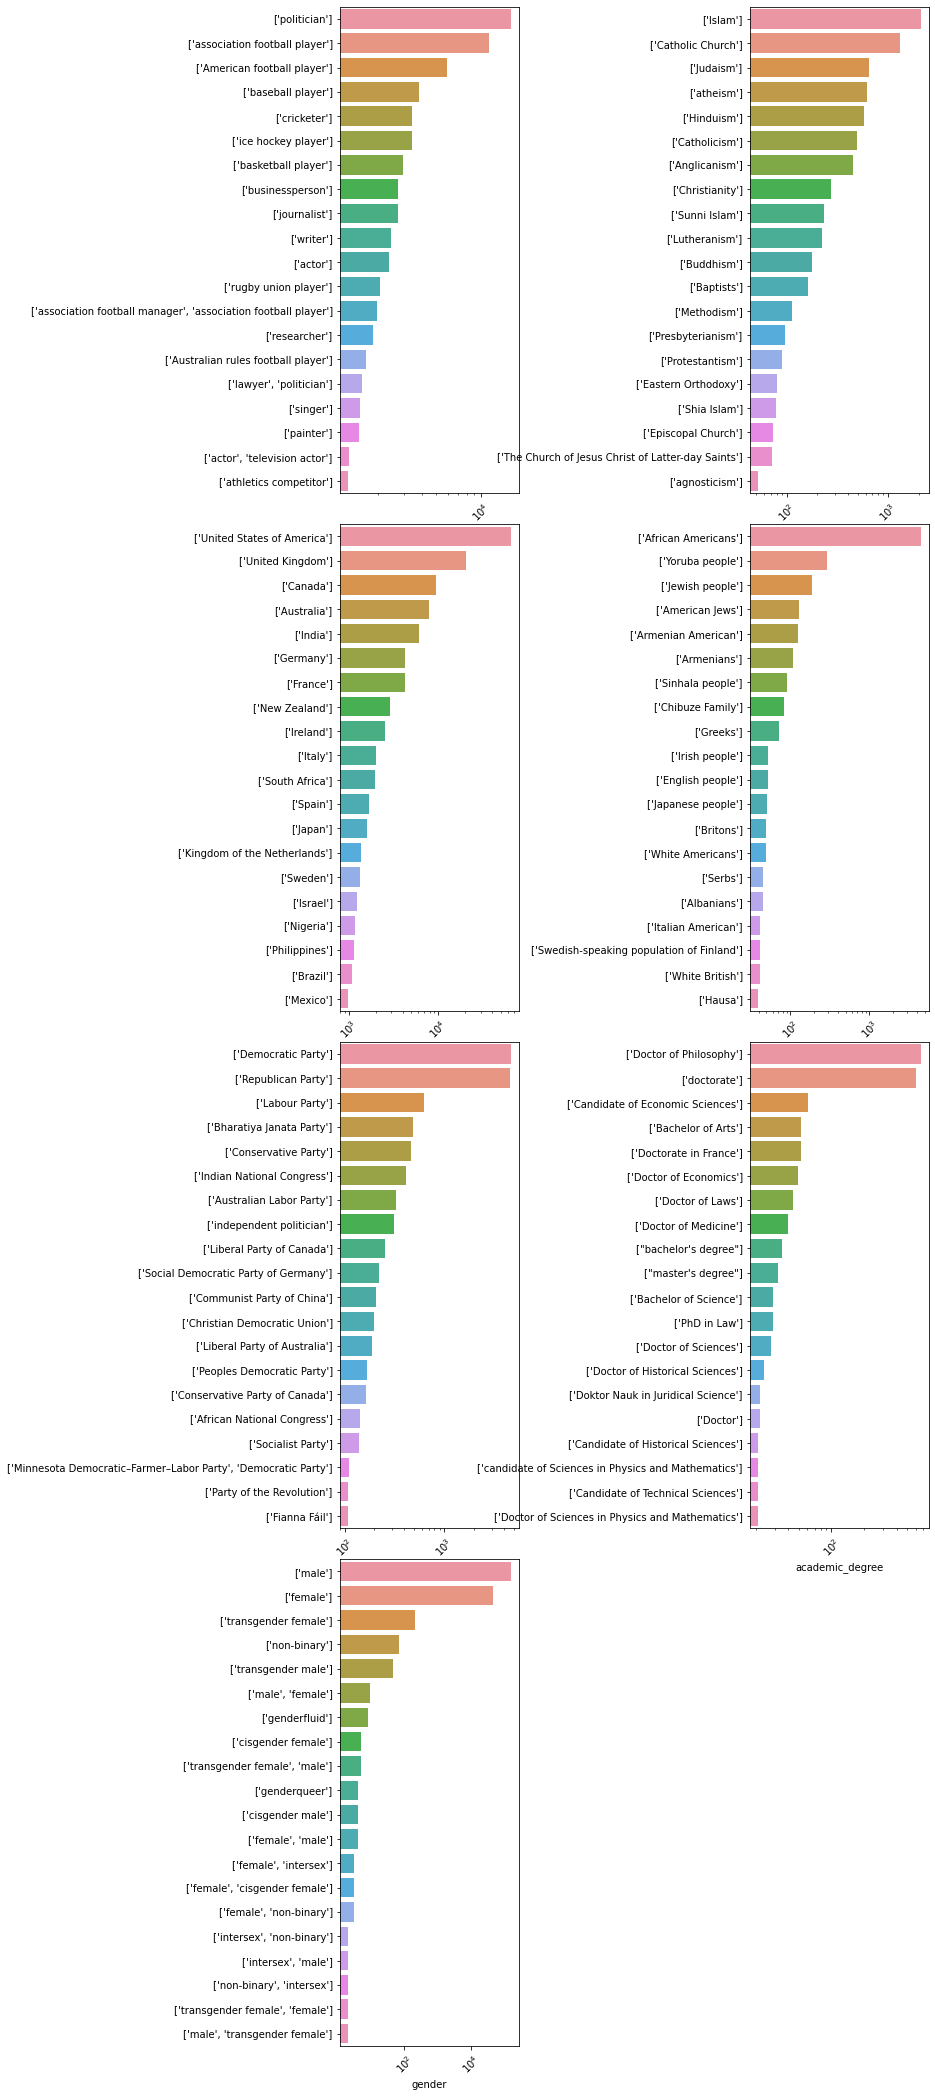

In [57]:
climate = speakers[speakers['climate']==1]
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]

fig, axs = plt.subplots(4,2, figsize=(10,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=5, w_pad=20, h_pad=1)

for idx, column in enumerate(columns_eval): 
    
    subdata=climate[column].explode().value_counts().drop('[]')

    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]])
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')


In [45]:
copie.drop(['occupation', 'religion', 'nationality', 
               'ethnic_group', 'party', 'academic_degree', 'id'], axis=1).to_csv('data/visu_data.csv', index=False)

# top 10

In [22]:
subdata.shape

(2324231, 8)

In [60]:
group=subdata.groupby('speaker')['numOccurrences'].agg(['count']).sort_values('count', ascending=False)

In [92]:
group

,count
speaker,
Narendra Modi,9428
President Donald Trump,8664
Bernie Sanders,7680
President Barack Obama,6390
Pope Francis,5345
...,...
Dale last,1
Master Manjunath,1
Master Jay,1


In [77]:
group.head(10).index

Index(['Narendra Modi', 'President Donald Trump', 'Bernie Sanders',
       'President Barack Obama', 'Pope Francis', 'President Obama',
       'President Trump', 'Justin Trudeau', 'Hillary Clinton',
       'Elizabeth Warren'],
      dtype='object', name='speaker')

In [101]:
group.values.tolist()

AttributeError: 'list' object has no attribute 'tolist'

TypeError: only size-1 arrays can be converted to Python scalars

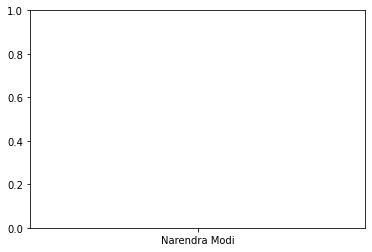

In [113]:
plt.plot(group.values[:10], group.head(10).index)


# temporal evolution  : 
Is there any temporal evolution in the mediatic coverage of the climate crisis ? If so, does it correlate with specific events ? 

In [2]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

In [3]:
subdata=pd.DataFrame()
for years, quotes in dico_clean.items() : 
    #quotes.date=quotes.fillna(0).date.map(lambda y : str(y).split("-")[0:2])#extract years and month of the quotation
    subdata = pd.concat([subdata, quotes])

In [170]:
from datetime import datetime

subdata.date.map(lambda y : datetime.strptime(y, '%Y-%m-%d %H:%M:%S'))


0        2020-02-24 12:45:00
1        2020-02-24 16:02:23
2        2020-04-01 11:25:48
3        2020-02-12 05:07:56
4        2020-01-08 16:59:00
                 ...        
424323   2015-03-24 05:09:00
424324   2015-03-20 22:09:56
424325   2015-04-20 21:04:00
424326   2015-10-25 12:20:43
424327   2015-01-29 11:11:35
Name: date, Length: 2324231, dtype: datetime64[ns]

In [178]:
subdata.sort_values(by='date', inplace=True)

In [181]:
subdata['date'] = pd.to_datetime(subdata['date']).dt.strftime('%Y-%m')

In [182]:
subdata.date

289243    2015-01
104070    2015-01
241602    2015-01
259163    2015-01
187676    2015-01
           ...   
38751     2020-04
935       2020-04
39957     2020-04
108748    2020-04
26872     2020-04
Name: date, Length: 2324231, dtype: object

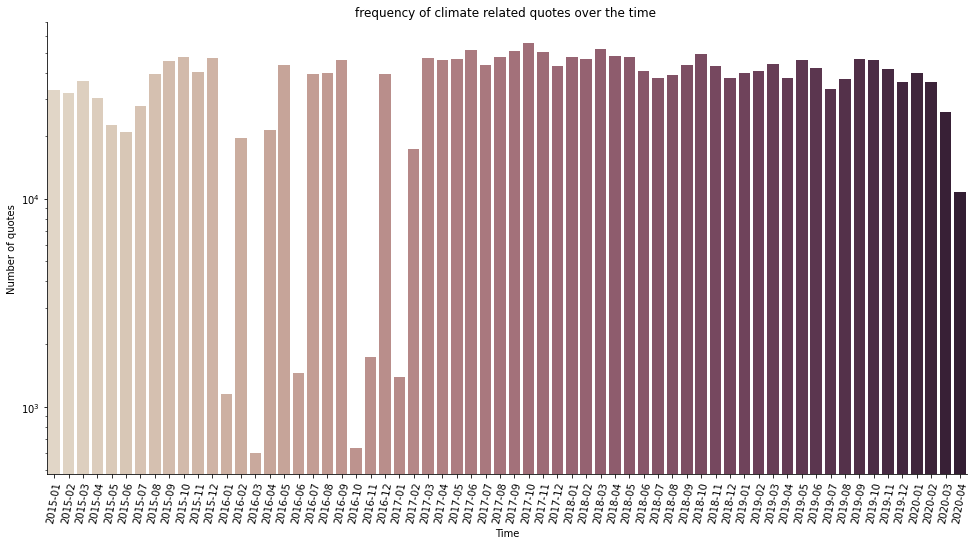

In [192]:
import seaborn as sns
ax=sns.catplot(data=subdata, x = 'date',  kind="count", 
               palette="ch:.25",height=7, aspect=2)
ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the time ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

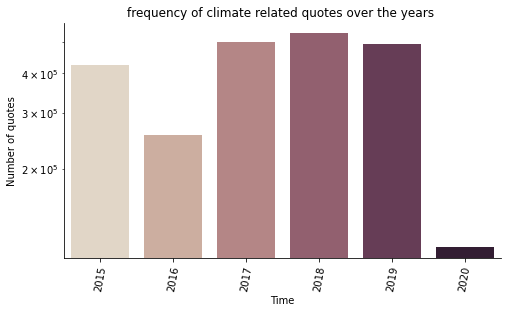

In [194]:
subdata['date'] = pd.to_datetime(subdata['date']).dt.strftime('%Y')
ax=sns.catplot(data=subdata, x = 'date',  kind="count", 
               palette="ch:.25",height=4, aspect=1.8)
ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the years ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

# supervised learning  : 
Based on the evolution of the profile of a person talking about climate in the media, can we predict what
characteristics will a climate-involved person have in the future 

In [2]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [3]:
data_original = pd.read_csv('data/visu_data.csv')

In [4]:
data_original.head(10)

,date_of_birth,gender,label,candidacy,climate,['association football player'],['politician'],['actor'],['writer'],['researcher'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,['male'],Douglas Adams,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,['male'],George W. Bush,"['2000 United States presidential election', '...",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,['male'],Neil Young,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1969,['male'],Harald Krichel,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1932,['male'],Andrei Tarkovsky,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1949,['female'],Meryl Streep,[],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1957,['male'],Donald Tusk,['2005 Polish presidential election'],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1921,['male'],Andrei Sakharov,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1950,['male'],Narendra Modi,['2014 Indian general election in Vadodara Lok...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1944,['male'],Ban Ki-moon,[],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data_features = data_original.drop(['candidacy', 'label', 'gender'], axis=1).copy()
data_features.head(3)

,date_of_birth,climate,['association football player'],['politician'],['actor'],['writer'],['researcher'],['painter'],['visual artist'],['journalist'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
[train, test] = split_set(data_features)

In [10]:
train_label=train.climate
train_features = train.drop('climate', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test.climate
test_features = test.drop('climate', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 2315712
Length of the test dataset : 579324


In [11]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

/var/folders/dp/xm3y4vf11sd5mzn0yd618jhm0000gn/T/ipykernel_12263/1385051995.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_features_std[c] = (train_features[c]-means[c])/stddevs[c]
/var/folders/dp/xm3y4vf11sd5mzn0yd618jhm0000gn/T/ipykernel_12263/1385051995.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features_std[c] = (test_features[c]-means[c])/stddevs[c]


,date_of_birth,['association football player'],['politician'],['actor'],['writer'],['researcher'],['painter'],['visual artist'],['journalist'],['singer'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,-0.427053,-0.307092,-0.24272,-0.162493,-0.134228,-0.112595,-0.110287,-0.107783,-0.103531,-0.103539,...,-0.001859,-0.001859,-0.001859,-0.001971,-0.001739,-0.001739,-0.00161,-0.001469,-0.001314,-0.001314
1,-0.746942,-0.307092,-0.24272,-0.162493,-0.134228,-0.112595,-0.110287,-0.107783,-0.103531,-0.103539,...,-0.001859,-0.001859,-0.001859,-0.001971,-0.001739,-0.001739,-0.00161,-0.001469,-0.001314,-0.001314
2,0.349821,-0.307092,-0.24272,-0.162493,-0.134228,-0.112595,-0.110287,-0.107783,-0.103531,-0.103539,...,-0.001859,-0.001859,-0.001859,-0.001971,-0.001739,-0.001739,-0.00161,-0.001469,-0.001314,-0.001314
3,-1.341022,-0.307092,-0.24272,-0.162493,-0.134228,-0.112595,-0.110287,-0.107783,-0.103531,-0.103539,...,-0.001859,-0.001859,-0.001859,-0.001971,-0.001739,-0.001739,-0.00161,-0.001469,-0.001314,-0.001314
4,-0.564148,-0.307092,-0.24272,-0.162493,-0.134228,-0.112595,-0.110287,-0.107783,-0.103531,-0.103539,...,-0.001859,-0.001859,-0.001859,-0.001971,-0.001739,-0.001739,-0.00161,-0.001469,-0.001314,-0.001314


In [17]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')

def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [14]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,train_label)

LogisticRegression(max_iter=10000)

In [15]:
prediction_proba = logistic.predict_proba(test_features_std)

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

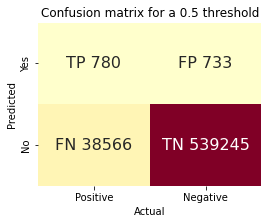

In [18]:
confusion_matrix_05 = compute_confusion_matrix(test_label, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [19]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.932
For the positive case, the precision is 0.516, the recall is 0.020 and the F1 score is 0.038
For the negative case, the precision is 0.933, the recall is 0.999 and the F1 score is 0.965


In [20]:
tmp = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
44,['Japan'],-0.307133
7,['visual artist'],-0.303341
50,['Poland'],-0.184153
1,['association football player'],-0.166395
68,['Pardo Brazilians'],-0.138367


<BarContainer object of 141 artists>

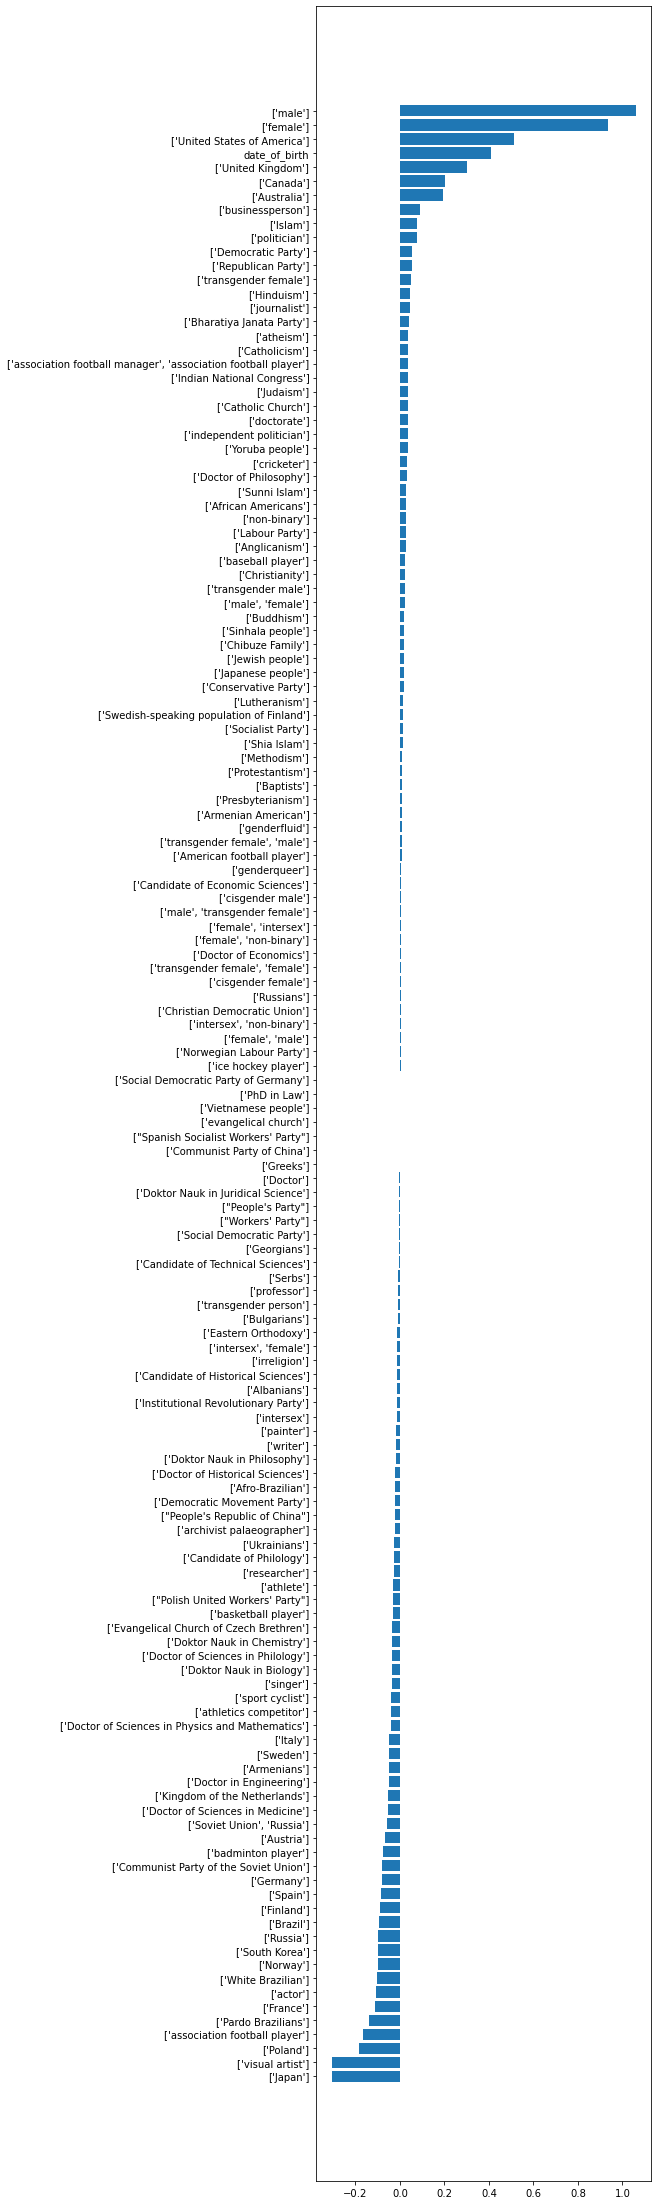

In [25]:
plt.subplots(figsize=(6,40))
plt.barh(features_coef.name, features_coef.value, alpha=1)

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [ ]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(train_features,train_label)
print(classification_report(test_label,gradient_booster.predict(test_feature)))

In [ ]:
print(gradient_booster.feature_importances_)

# plot
pyplot.bar(range(len(gradient_booster.feature_importances_)), gradient_booster.feature_importances_)
pyplot.show()